<a href="https://colab.research.google.com/github/sagar-rathod/PytorchDeepML/blob/master/examples/Image_Regression_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Regression Example

In this example, we will see how to solve [Cube Orientation Problem](https://www.aicrowd.com/challenges/aicrowd-blitz-may-2020/problems/orientme) hosted on AICrowd using deepml. 

First, lets download the train and test dataset

In [ ]:
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/orientme/v0.2/training.tar.gz
!tar -xzf training.tar.gz
!rm training.tar.gz

In [ ]:
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/orientme/v0.2/test.tar.gz
!tar -xzf test.tar.gz
!rm  test.tar.gz

Once downloaded and extracted, we can check the number of images in **tranining** folder

In [1]:
# Number of train images
!ls training/images | wc -l

5000


In [2]:
# Number of test Images
!ls images | wc -l

5001


Install [deepml](https://github.com/sagar-rathod/PytorchDeepML) libarary.

In [ ]:
!pip install deepml

Once successfuly installed, lets import the number of required libraries and set a **seed** value

In [3]:
import pandas as pd
import numpy as np
import torch

import matplotlib as mpl
%matplotlib inline

# Uncomment following line if your notebook theme is black
mpl.rcParams['text.color'] = "white"

seed = 7

np.random.seed(seed)
torch.random.manual_seed(seed)

In [4]:
train_dir = 'training/images'
labels_file = 'training/labels.csv'
test_dir = 'images'

For this problem, we have been provided the separate label file for training set, so let's read that and see some contents.

In [5]:
labels_df = pd.read_csv(labels_file)
labels_df['xRot'] = labels_df['xRot'].astype(np.float32)
labels_df.head()

,filename,xRot
0,000000.jpg,336.838898
1,000001.jpg,148.484375
2,000002.jpg,244.821655
3,000003.jpg,222.700623
4,000004.jpg,172.358124


As usually in any ML problem, we divide the provided training dataset in two parts: train and validation. Let's do that.

In [6]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(labels_df, random_state=seed)
train.shape, val.shape

((3750, 2), (1250, 2))

We are going to use **ImageNet** pretrained **resnet18** model for this problem. As it accepts **224** size of image as input, we have to define torch transformation for training and validation dataset

In [7]:
import torchvision
from deepml.datasets import ImageDataFrameDataset
from deepml import constants

transforms = torchvision.transforms.Compose([
                                             torchvision.transforms.CenterCrop(224),
                                             torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(mean=constants.IMAGENET_MEAN, std=constants.IMAGENET_STD, inplace=True),
                                             ])

<p> As in case our input dataframe, we need to provide image file path column name where these images will be looked up inside train dir. </p>
<p>Also provide target column name which <b>isxRot</b> that we need to predict the rotation of cubic image. </p>

In [8]:
train_dataset = ImageDataFrameDataset(train, image_file_name_column='filename', target_columns='xRot', 
                                          image_dir=train_dir, transforms=transforms)

val_dataset = ImageDataFrameDataset(val, image_file_name_column='filename', target_columns='xRot', 
                                        image_dir=train_dir, transforms=transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

Let's visiualise some images from tranining set. As we have provided Imagenet mean and std_dev to transform input images, similarly we need to provide Imagenet reverse transorm to visualize it properly. However this is optional and you may receive warnings

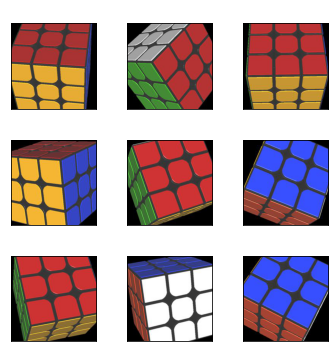

In [9]:
from deepml.visualize import show_images_from_loader
from deepml.transforms import ImageNetInverseTransform

inverse_transform = ImageNetInverseTransform()

show_images_from_loader(val_loader, inverse_transform)

Now let see how to quickly train model using **deepml**.

Create **resnet18** model and modify it's head/last layer because we need to predict **single floating integer**, that is the degree of cube orientation between 0 and 360 degree. 

In [10]:
model = torchvision.models.resnet18(pretrained=True)

# freeze early layers
for param in model.parameters():
    if param.requires_grad:
        param.requires_grad = False

# Modify head
model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)

Choose loss function, optimizer and create **deepml.train.Learner** object.

In [11]:
from deepml.tasks import ImageRegression
from deepml.train import Learner
from deepml.losses import RMSELoss

work_dir = 'resnet18'
regression = ImageRegression(model, work_dir)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = RMSELoss()

learner = Learner(regression, optimizer, criterion)

**deepml** logs its training and validation metrics into tensorboard while model learns from the data. You can also visualize random training images and model prediction in tensorboard/Images section.

In [15]:
# Enable Tensorboard on colab
%load_ext tensorboard

# Run tensorboard and provide model working directory
%tensorboard --logdir 'resnet18'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 6076), started 0:20:51 ago. (Use '!kill 6076' to kill it.)

Let's fit the learner on train loader and use tensorboard to monitor training progress

In [13]:
from torch.nn import MSELoss

# metrics to evaluate 
metrics = [("mse", MSELoss())]

# Here, we are passing inverse transform to see those images on tensorboard
learner.fit(train_loader, val_loader, epochs=5, image_inverse_transform=inverse_transform,
            metrics=metrics)

Epoch 1/5:


Saving best validation model.
Epoch 2/5:


Saving best validation model.
Epoch 3/5:


Saving best validation model.
Epoch 4/5:


Saving best validation model.
Epoch 5/5:


Saving best validation model.


In [14]:
# Train for more epochs
learner.fit(train_loader, val_loader, epochs=2, image_inverse_transform=inverse_transform, metrics=metrics)

Epoch 6/7:


Saving best validation model.
Epoch 7/7:


Saving best validation model.


In [16]:
# Save model weights
learner.save('current_model.pt', save_optimizer_state=True, epoch=7)

'resnet18\\current_model.pt'

Let's, see some random samples of prediction from validation data

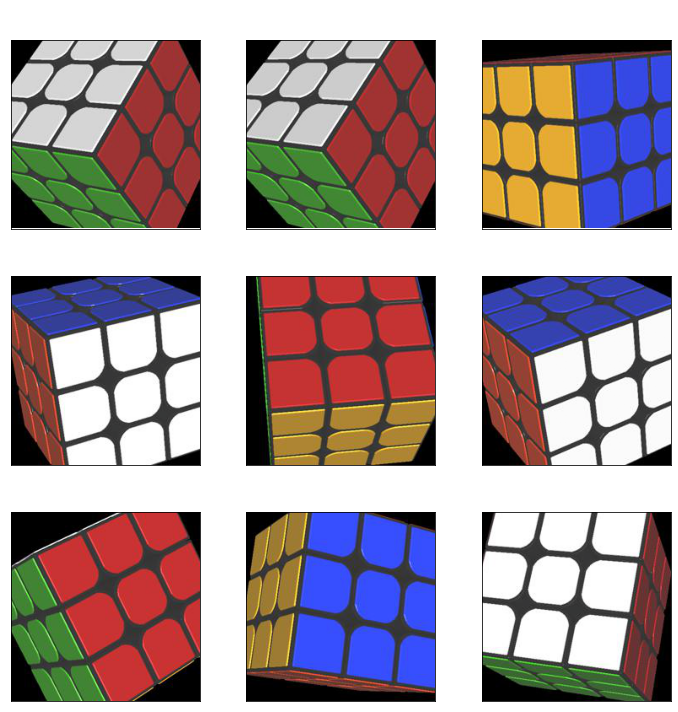

In [17]:
learner.show_predictions(val_loader, image_inverse_transform=inverse_transform)

Once the model is trained, lets use it to perform prediction on test data. Since provided test data is list of images in a folder. We can use ImageListDataset

In [23]:
from deepml.datasets import ImageListDataset
 
test_dataset = ImageListDataset('images', transforms)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, num_workers=4)
test_predictions, filenames = learner.predict(test_loader)

Read provided sample submission file and create our final submission csv.

In [25]:
submission = pd.DataFrame(columns=['filename', 'xRot'])

In [28]:
submission['xRot'] = np.squeeze(test_predictions.numpy())
submission['filename'] = filenames

submission.head()

,filename,xRot
0,005000.jpg,100.679131
1,005001.jpg,133.063599
2,005002.jpg,130.689621
3,005003.jpg,121.908844
4,005004.jpg,104.416763


In [29]:
submission.to_csv('submission.csv', index=False)